In [1]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
from torch import optim
from torch.nn import init
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
device

device(type='cuda')

In [2]:
df = pd.read_csv("train.csv")
val, train = df.iloc[:(len(df.index) // 10)], df.iloc[(len(df.index) // 10):]
print(f"Total Samples: {len(df.index)}")
print(f"Train Samples: {len(train)}, Val Samples: {len(val)}")

Total Samples: 42000
Train Samples: 37800, Val Samples: 4200


In [3]:
# make sure we have more or less evenly distributed samples in train and val
count_df = pd.DataFrame(df["label"].value_counts())
count_df["val"] = pd.DataFrame(val["label"].value_counts())
count_df["train"] = pd.DataFrame(train["label"].value_counts())
count_df

,label,val,train
1,4684,460,4224
7,4401,427,3974
3,4351,386,3965
9,4188,401,3787
2,4177,454,3723
6,4137,436,3701
0,4132,425,3707
4,4072,409,3663
8,4063,404,3659
5,3795,398,3397


Label: 1


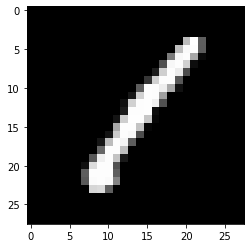

In [4]:
sampled_image = df.iloc[0]
label = sampled_image.pop("label")
print("Label:", label)
plt.imshow(np.reshape(sampled_image.values, (28, 28)), cmap="gray")

In [5]:
class MNISTds(Dataset):

    def __init__(self, df, test=False):
        super().__init__()
        self.labels = df.pop("label").values
        self.imgs = df.values
        self.test = test

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, indx):
        label = self.labels[indx]
        oh_label = torch.zeros(10)
        oh_label[label] = 1 - np.random.random() * 0.15 if not self.test else 1

        img = torch.tensor(self.imgs[indx]).float() / 255
        return (img, oh_label)

train_ds = MNISTds(train)
val_ds = MNISTds(val, test=True)

In [6]:
def weights_init(layer):
    if type(layer) == nn.Linear:
        init.normal_(layer.weight)
        layer.bias.data.normal_()

def conv_init(layer):
    if type(layer) == nn.Conv2d:
            init.normal_(layer.weight, mean=0, std=0.2)
            #layer.bias.data.normal_()

In [7]:
class DenseClassifier(nn.Module):

    # dropout seems to worsen performance so im not using it in this model
    def __init__(self):
        super().__init__()
        #self.droprate = 0.3
        self.leaky = nn.LeakyReLU(0.2)
        self.inp = nn.Linear(in_features=784, out_features=1440)
        self.bn1 = nn.BatchNorm1d(num_features=1440)
        #self.drop1 = nn.Dropout(self.droprate)

        self.fc1 = nn.Linear(in_features=1440, out_features=2048)
        self.bn2 = nn.BatchNorm1d(num_features=2048)
        #self.drop2 = nn.Dropout(self.droprate)

        self.fc2 = nn.Linear(in_features=2048, out_features=1440)
        self.bn3 = nn.BatchNorm1d(num_features=1440)
        #self.drop3 = nn.Dropout(self.droprate)

        self.out = nn.Linear(in_features=1440, out_features=10)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.inp(x)
        x = self.bn1(x)
        x = self.leaky(x)
        #x = self.drop1(x)

        x = self.fc1(x)
        x = self.bn2(x)
        x = self.leaky(x)
        #x = self.drop2(x)

        x = self.fc2(x)
        x = self.bn3(x)
        x = self.leaky(x)
        #x = self.drop3(x)

        x = self.sig(self.out(x))
        return x


In [8]:
class CNNClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.leaky = nn.LeakyReLU(0.2)
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(num_features=64)

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=2, stride=2)
        self.bn2 = nn.BatchNorm2d(num_features=128)

        self.conv3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)
        self.bn3 = nn.BatchNorm2d(num_features=128)

        self.out = nn.Conv2d(in_channels=128, out_channels=10, kernel_size=3)
        self.flatten = nn.Flatten()
        self.sig = nn.Sigmoid()


    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.conv1(x)
        #x = self.bn1(x)
        x = self.leaky(x)

        x = self.conv2(x)
        #x = self.bn2(x)
        x = self.leaky(x)

        x = self.conv3(x)
        #x = self.bn3(x)
        x = self.leaky(x)

        x = self.out(x)
        x = self.flatten(x)
        x = self.sig(x)
        return x

In [9]:
classifier = DenseClassifier().to(device)
classifier.apply(conv_init)

DenseClassifier(
  (leaky): LeakyReLU(negative_slope=0.2)
  (inp): Linear(in_features=784, out_features=1440, bias=True)
  (bn1): BatchNorm1d(1440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1440, out_features=2048, bias=True)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=2048, out_features=1440, bias=True)
  (bn3): BatchNorm1d(1440, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=1440, out_features=10, bias=True)
  (sig): Sigmoid()
)

In [10]:
MSE = nn.MSELoss()
lr = 0.0001
optimizer = optim.Adam(classifier.parameters(), lr=lr)
BATCH_SIZE = 256

In [11]:
def evaluate_model(model, data):
    loader = iter(DataLoader(data, batch_size=BATCH_SIZE, shuffle=False))
    correct = 0
    incorrect = 0
    for batch in loader:
        images, labels = batch
        predict = classifier(images.float().cuda()).cpu()
        for label, prediction in zip(labels, predict):
            if torch.argmax(label) == torch.argmax(prediction):
                correct += 1
            else:
                incorrect += 1
    return correct / (correct + incorrect)

In [12]:
def train_model(model, data, epochs):
    data = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True)
    losses = []
    epoch_losses = []
    for epoch in range(epochs):
        loader = iter(data)
        with tqdm(total=len(loader), desc=f"Training for epoch {epoch} of {epochs}") as progress:
            for batch in loader:
                images, labels = batch
                predict = classifier(images.float().cuda())
                loss = MSE(predict, labels.cuda())
                loss.backward()
                optimizer.step()
                losses.append(loss.detach().item())
                progress.update(1)
        epoch_loss = evaluate_model(classifier, val_ds)
        # try:
        #     if epoch_loss > epoch_losses[-1]:
        #         break
        # except IndexError:
        #     pass
        epoch_losses.append(epoch_loss)
        print(f"Validation Loss after Epoch {epoch}: {epoch_loss}")

    plt.figure(figsize=(10, 5))
    plt.title("Loss for classifier")
    plt.plot(losses)
    plt.show()

Training for epoch 59 of 60: 100%|██████████| 148/148 [00:03<00:00, 41.47it/s]
Validation Loss after Epoch 59: 0.969047619047619


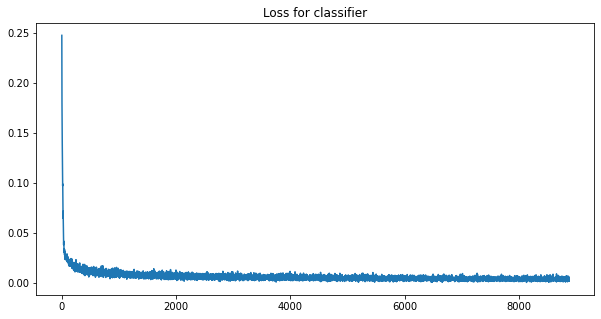

In [13]:
print(f"Accuracy before training: {evaluate_model(classifier, val_ds)}")
train_model(classifier, train_ds, 60)

In [14]:
predict_images = torch.tensor(pd.read_csv("test.csv").values)
predictions = classifier(predict_images.cuda().float() / 255)
predictions = np.array([torch.argmax(prediction).item() for prediction in predictions])
submission = pd.DataFrame(predictions, columns=["Label"])
submission.index = np.arange(1, len(submission) + 1)
submission.index.name = "ImageID"
submission.to_csv("submission.csv")